In [4]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
import keras
import os

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt


seed = 360

from datasets import make_data, train_val_test_split, tensorflow_dataset
from models import poisson_glm, mixture_poissons
from metrics import poisson_nll, get_bpr_loss_func, get_penalized_bpr_loss_func, top_k_idx, mixture_poi_loss, get_penalized_bpr_loss_func_mix, mix_bpr
tf.config.run_functions_eagerly(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


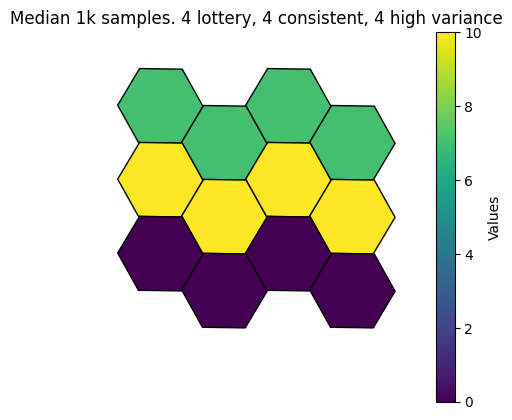

In [6]:
# tracts/distributions
S=12
# history/features
H = 50
# total timepoints
T= 500
# K for bpr
K=4
num_components=4

input_shape = (H,S)

consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4

sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')


X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-2, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(1, H)
    assert(np.all(X_THS[t, h-1, :] == y_TS[t-(H-h), :]))

(train_X_THS, train_y_TS), \
(val_X_THS, val_y_TS), \
(test_X_THS, test_y_TS) = train_val_test_split(X_THS, y_TS, train_pct=0.6, test_pct=0.2)

train_dataset = tensorflow_dataset(train_X_THS, train_y_TS, seed=seed+200,batch_size=500)
val_dataset = tensorflow_dataset(val_X_THS, val_y_TS, seed=seed+300,batch_size=500)

In [7]:
len(train_dataset)

1

In [8]:
mix_model, mix_weights  = mixture_poissons(poisson_glm, input_shape, num_components=num_components)

In [9]:
# penalty = 0 for NLL only
penalty = 0
bpr_threshold = 0.45
learning_rate = 0.005

negative_bpr_K = get_bpr_loss_func(K)
penalized_bpr_loss = get_penalized_bpr_loss_func_mix(mixture_poi_loss, K, penalty, bpr_threshold)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [10]:
def training_loop(model, loss_func, optimizer, num_epochs, verbose=False):

    losses = {}
    losses['train'] = {}
    losses['val'] ={}
    losses['train']['loss']=[]
    losses['train']['nll']=[]
    losses['train']['bpr']=[]
    losses['val']['loss']=[]
    losses['val']['nll']=[]
    losses['val']['bpr']=[]

    for epoch in range(num_epochs):

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                y_preds = model(x_batch_train, training=True)
                loss_value = loss_func(y_batch_train, y_preds)
                
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        y_preds = model(train_X_THS)
        loss = loss_func(train_y_TS, y_preds)
        loss = tf.reduce_mean(loss)
        bpr = mix_bpr(train_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
        nll = mixture_poi_loss(train_y_TS, y_preds)
        nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
        losses['train']['loss'].append(loss)
        losses['train']['nll'].append(nll)
        losses['train']['bpr'].append(bpr)
        if verbose:
            print(f'{epoch}: {loss}')
        y_preds = model(val_X_THS)
        loss = loss_func(val_y_TS, y_preds)
        loss = tf.reduce_mean(loss)
        bpr = mix_bpr(val_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
        nll = mixture_poi_loss(val_y_TS, y_preds)
        nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
        losses['val']['loss'].append(loss)
        losses['val']['nll'].append(nll)
        losses['val']['bpr'].append(bpr)

    return losses
    

In [15]:
losses = training_loop(mix_model, penalized_bpr_loss, optimizer, 1250, verbose=True)

0: 98.34849548339844
1: 98.34046936035156
2: 98.33243560791016
3: 98.32440948486328
4: 98.31637573242188
5: 98.30833435058594
6: 98.30030059814453
7: 98.2922592163086
8: 98.28421020507812
9: 98.27616882324219
10: 98.26811981201172
11: 98.26007080078125
12: 98.25202178955078
13: 98.24398040771484
14: 98.23592376708984
15: 98.22787475585938
16: 98.2198257446289
17: 98.21177673339844
18: 98.20372009277344
19: 98.19566345214844
20: 98.18761444091797
21: 98.17955780029297
22: 98.17150115966797
23: 98.1634521484375
24: 98.15540313720703
25: 98.1473388671875
26: 98.13928985595703
27: 98.13123321533203
28: 98.12319946289062
29: 98.11514282226562
30: 98.10710144042969
31: 98.09905242919922
32: 98.09101867675781
33: 98.08297729492188
34: 98.0749282836914
35: 98.06688690185547
36: 98.05884552001953
37: 98.05081176757812
38: 98.04279327392578
39: 98.03475952148438
40: 98.0267333984375
41: 98.01870727539062
42: 98.01068878173828
43: 98.00267028808594
44: 97.99465942382812
45: 97.98665618896484
46: 

In [14]:
from functools import partial
val_preds, mix_weights = mix_model(val_X_THS)

mixture_pred = tf.einsum('ijk,kj->ij', val_preds, mix_weights)

# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(mixture_pred)
print(f'avg pred:{np.mean(top_K_ids, axis=0)}')
print(f'avg pred per component: {tf.reduce_mean(tf.map_fn(top_K_idx_func, tf.transpose(val_preds,(2,0,1))), axis=1)}')

avg pred:[0.04 0.12 0.02 0.33 0.31 0.43 0.38 0.3  0.54 0.5  0.46 0.57]
avg pred per component: [[0.33 0.16 0.03 0.01 0.19 0.4  0.35 0.37 0.56 0.6  0.52 0.48]
 [0.36 0.15 0.07 0.   0.36 0.33 0.4  0.32 0.53 0.48 0.45 0.55]
 [0.34 0.18 0.03 0.   0.35 0.36 0.37 0.35 0.47 0.48 0.52 0.55]
 [0.36 0.12 0.04 0.01 0.23 0.4  0.39 0.32 0.56 0.59 0.5  0.48]]
